In [4]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from stable_baselines3 import DQN
from gym import spaces
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Load & Preprocess Stock Data
df = pd.read_csv("./final_stock_data.csv", parse_dates=["Date"])
df = df.sort_values(by=["Date"])

df["Close"].replace(0, np.nan, inplace=True)
df["Close"].fillna(method="ffill", inplace=True)

# Feature Scaling
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Train-Test Split
train_size = int(len(df) * 0.8)
df_train, df_test = df.iloc[:train_size], df.iloc[train_size:]

# ✅ Custom Gym Environment
class StockTradingEnv(gym.Env):
    def __init__(self, df, transaction_cost=0.001):
        super(StockTradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.transaction_cost = transaction_cost
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(len(numeric_cols),), dtype=np.float32)
        self.initial_balance = 100000
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.portfolio_value = self.balance
        return self._next_observation()

    def _next_observation(self):
        obs = self.df.iloc[self.current_step][numeric_cols].values
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        current_price = self.df.iloc[self.current_step]["Close"]

        if current_price <= 0 or np.isnan(current_price):
            current_price = 1  # Prevent errors

        prev_portfolio_value = self.portfolio_value

        if action == 1:  # Buy
            num_shares = self.balance // current_price
            cost = num_shares * current_price * (1 + self.transaction_cost)
            if self.balance >= cost and num_shares > 0:
                self.shares_held += num_shares
                self.balance -= cost

        elif action == 2 and self.shares_held > 0:  # Sell
            sell_value = self.shares_held * current_price * (1 - self.transaction_cost)
            self.balance += sell_value
            self.shares_held = 0

        self.portfolio_value = self.balance + (self.shares_held * current_price)
        
        # ✅ Normalize Reward Calculation
        reward = (self.portfolio_value - prev_portfolio_value) / (abs(prev_portfolio_value) + 1e-6)

        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        return self._next_observation(), reward, done, {}

# ✅ Create Training & Testing Environments
env_train = StockTradingEnv(df_train)
env_test = StockTradingEnv(df_test)

# ✅ Define Improved TDQN Model
model = DQN(
    "MlpPolicy", 
    env_train, 
    verbose=1, 
    learning_rate=0.0001,  # Lower learning rate for stability
    batch_size=128,  # Smaller batch size for better updates
    buffer_size=100000,  # Experience replay
    learning_starts=10000,  # Delay learning for stable training
    target_update_interval=10000,  # More stable target updates
    exploration_fraction=0.3,  # Increased exploration period
    exploration_final_eps=0.01,  # Lower final epsilon for better exploitation
)

# ✅ Training with Metrics Logging
metrics = []
total_timesteps = 1000000  # Increased training time
log_interval = 10000

with tqdm(total=total_timesteps, desc="Training TDQN") as pbar:
    for step in range(total_timesteps // log_interval):
        model.learn(total_timesteps=log_interval, log_interval=10)
        
        # Evaluate Model on Test Data
        obs = env_test.reset()
        done = False
        rewards = []
        predictions = []
        actuals = []
        while not done:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env_test.step(action)
            rewards.append(reward)
            predictions.append(env_test.portfolio_value)
            actuals.append(env_test.df.iloc[env_test.current_step]["Close"])
        
        # ✅ Compute Metrics
        mae = mean_absolute_error(actuals, predictions)
        mse = mean_squared_error(actuals, predictions)
        huber_loss = np.mean(np.where(np.abs(np.array(actuals) - np.array(predictions)) < 1, 
                                    0.5 * (np.array(actuals) - np.array(predictions)) ** 2, 
                                    np.abs(np.array(actuals) - np.array(predictions)) - 0.5))

        # ✅ Fetch Training Loss
        training_loss = model.logger.name_to_value.get("train/loss", None)
        testing_loss = np.mean(np.abs(np.array(rewards)))  # Absolute rewards as proxy

        metrics.append({
            "Step": step * log_interval, 
            "MAE": mae, 
            "MSE": mse, 
            "Huber": huber_loss,
            "Training_Loss": training_loss if training_loss is not None else 0.0,
            "Testing_Loss": testing_loss
        })

        pbar.update(log_interval)

# ✅ Save Model & Metrics
model.save("tdqn_trading_model_improved")
pd.DataFrame(metrics).to_csv("training_metrics.csv", index=False)

print("✅ Improved TDQN Model Trained & Metrics Saved Successfully!")


/home/ankit/miniconda3/envs/tDRL_env/lib/python3.8/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Training TDQN: 100%|██████████| 1000000/1000000 [09:29<00:00, 1756.42it/s]

✅ Improved TDQN Model Trained & Metrics Saved Successfully!


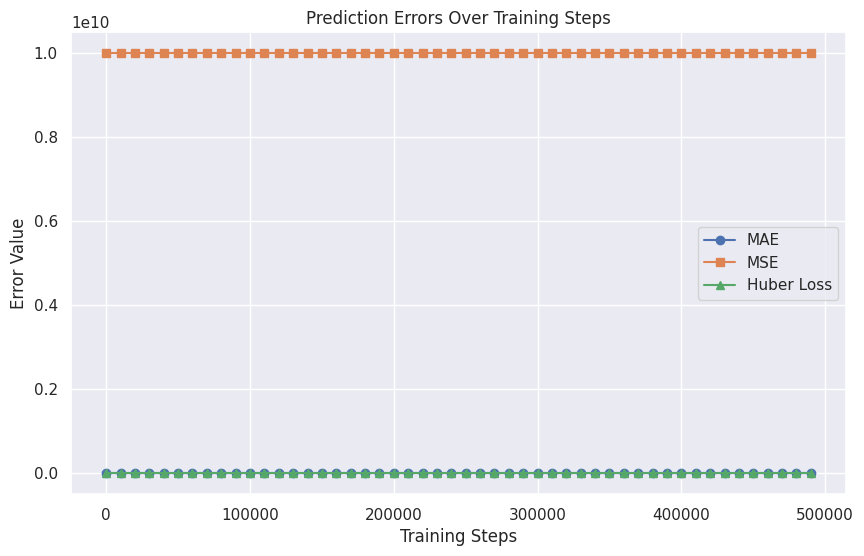

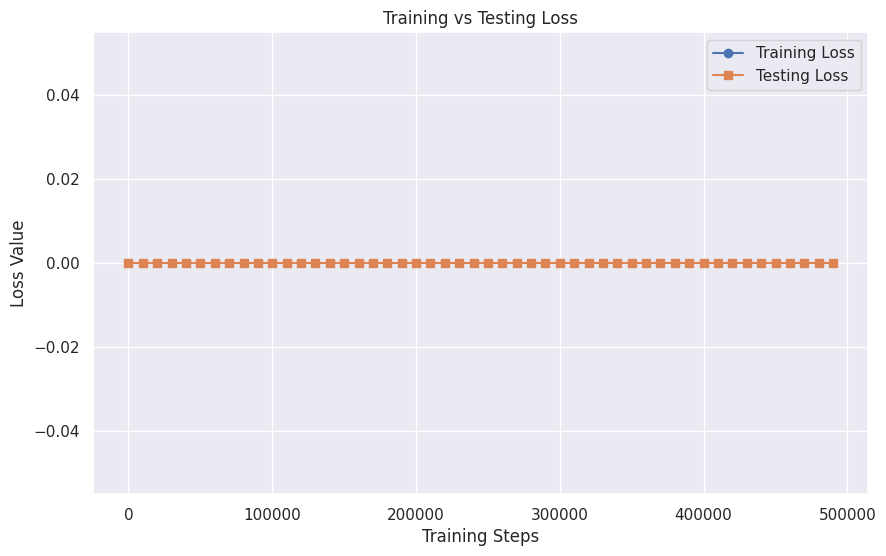

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Training Metrics
metrics_df = pd.read_csv("training_metrics.csv")

# Set Style
sns.set_theme(style="darkgrid")

# 📈 MAE, MSE, Huber Loss Over Steps
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Step"], metrics_df["MAE"], label="MAE", marker="o")
plt.plot(metrics_df["Step"], metrics_df["MSE"], label="MSE", marker="s")
plt.plot(metrics_df["Step"], metrics_df["Huber"], label="Huber Loss", marker="^")
plt.xlabel("Training Steps")
plt.ylabel("Error Value")
plt.title("Prediction Errors Over Training Steps")
plt.legend()
plt.show()

# 📉 Training Loss vs. Testing Loss
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Step"], metrics_df["Training_Loss"], label="Training Loss", marker="o")
plt.plot(metrics_df["Step"], metrics_df["Testing_Loss"], label="Testing Loss", marker="s")
plt.xlabel("Training Steps")
plt.ylabel("Loss Value")
plt.title("Training vs Testing Loss")
plt.legend()
plt.show()
